<a href="https://colab.research.google.com/github/jamespan1118/Xenopus_signal_processing/blob/main/Wave_Envelope.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Load packages and libraries

In [10]:
import librosa
from librosa import display
import matplotlib.pyplot as plt
import numpy as np
import pywt
import seaborn as sns
import statistics
import time
import scipy
from scipy import signal
from scipy.io.wavfile import write
from scipy.ndimage import gaussian_filter1d

##Checking running environment information

In [2]:
#checking runtime info
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

#checking RAM
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Fri Jul  8 20:03:12 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

##Defining data processing functions



In [3]:
def abs_hilbert_envelope(samples):
  start_time = time.time()
  #load samples
  sample_length = len(samples)
  #execute hilbert transform and taking absolute value
  hilbert_signal = abs(signal.hilbert(samples))
  #calculate execution time
  end_time = time.time()
  execution_time = end_time - start_time
  return hilbert_signal, sample_length, execution_time

In [24]:
# generate envelope using continous wavelet transform
def cwt_envelope(samples,scale=[90],wavelet='morl',sigma=100):
  start_time = time.time()
  sample_length = len(samples)
  #step 1: perform cwt
  coef, freqs=pywt.cwt(samples,scale,wavelet)
  #step 2: taking the power
  #powered_signal = coef.mean(axis=0)**2
  #step 3: 1d Gaussian filter
  cwt_smoothed_signal = gaussian_filter1d(coef.mean(axis=0), sigma)
  end_time = time.time()
  execution_time = end_time - start_time
  return cwt_smoothed_signal,sample_length,execution_time

In [6]:
def noise_filter(noise_file,signal,sigma=100,sampling_rate=44100,peak_height=0.001):
  #load audio files
  samples_noise, sampling_rate = librosa.load(noise_file,sr=sampling_rate)
  #get noise peaks
  noise_smoothed = gaussian_filter1d(abs(samples_noise),sigma)
  noise_peaks, _ = scipy.signal.find_peaks(noise_smoothed,height=peak_height)
  #filtering
  for i in noise_peaks:
    signal[int(i-(sigma*10/2)):int(i+(sigma*10/2))]=0
  return signal

In [72]:
from IPython.core.pylabtools import figsize
#get statistics on rapping IPI
def get_rapping_IPI_stats(peak_indices_list,x_time):
  IPI = []
  for i in range(0,len(peak_indices_list)-1):
    front = peaks[i]
    back = peaks[i+1]
    difference = x_time[back] - x_time[front]
    IPI.append(difference)
  #Assumption: Rapping is categorized by 3 or more consecutive pulses within 1 second.
  i=0
  IPI_processed = []
  while (i < (len(IPI)-2)):
  #while(0):
    if((IPI[i]+IPI[i+1])<1):
      IPI_processed.append(IPI[i])
      IPI_processed.append(IPI[i+1])
      k = 2
      while(1):
        if((IPI[i+k]<0.5)and(i+k <(len(IPI)-1))):
          IPI_processed.append(IPI[i+k])
          k=k+1
        else:
          i = i+k+1
          break
    else:
      i=i+1
  #generate statistics for rapping IPI plot
  st_dev = statistics.pstdev(IPI_processed)
  mean = statistics.mean(IPI_processed)
  median = statistics.median(IPI_processed)
  plt.figure(figsize=(20,5))
  sns.distplot(IPI_processed)
  plt.axvline(mean,color="grey",label="mean",linestyle='--')
  plt.axvline(median,color="black",label="median",linestyle='--')
  plt.legend()
  plt.show()
  return IPI_processed, mean, median, st_dev

##Loading audio file

In [7]:
#loading the file
file_path = "/content/01-F818D-F8387-220616_0456_8min_selection (1)_female_filtered.wav"
samples, sampling_rate = librosa.load(file_path,sr=44100)

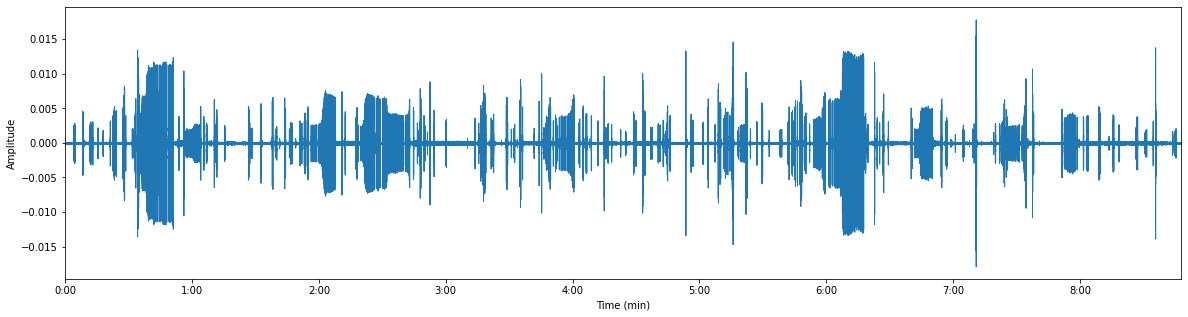

In [11]:
#plotting the audio data in time domain
plt.figure(figsize=(20,5))
librosa.display.waveplot(y=samples,sr=sampling_rate)

duration = len(samples)/sampling_rate
x_time = np.arange(0,duration,1/sampling_rate) #time vector

plt.xlabel("Time (min)")
plt.ylabel("Amplitude")
plt.show()

##Comparing running time between two methods

In [26]:
#compare running time
hilbert_time =[]
cwt_time = []
for i in range(1,len(samples),10000000):
  running_sample = samples[0:i]
  _, _, execution_time_h = abs_hilbert_envelope(running_sample)
  _, _, execution_time_c = cwt_envelope(running_sample)
  hilbert_time.append(execution_time_h)
  cwt_time.append(execution_time_c)

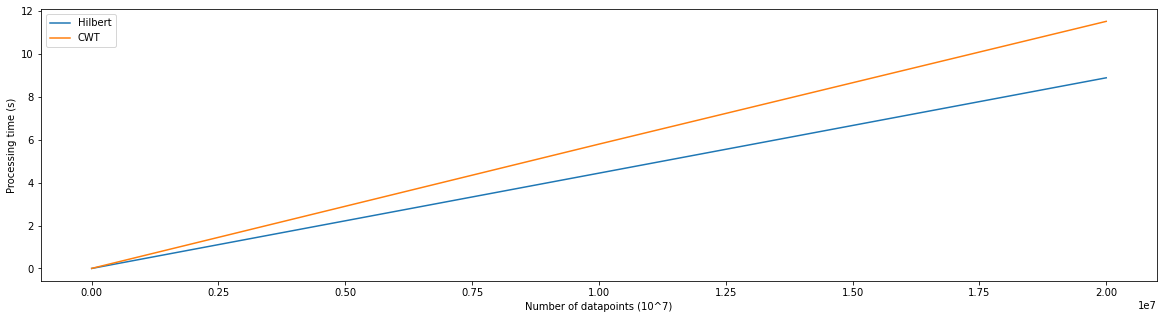

In [33]:
#plot datapoints vs. processing time graph
plt.figure(figsize=(20,5))
sample_size = np.arange(1,len(samples),10000000)
plt.plot(sample_size,hilbert_time,label='Hilbert')
plt.plot(sample_size,cwt_time,label='CWT')
plt.legend()
plt.ylabel("Processing time (s)")
plt.xlabel("Number of datapoints (10^7)")
plt.show()

##Apply functions to signals

In [31]:
#assumption: peaks of calling are at least 0.025 seconds apart
hilbert_signal, _, _ = abs_hilbert_envelope(samples)
#filter out noise
noise_filter('/content/01-F818D-F8387-220616_0456_8min_selection (1)_noise.wav',hilbert_signal)
#find peaks using filtered hilbert signal
peaks, _  = scipy.signal.find_peaks(hilbert_signal,height=0.0005,distance=0.025*44100)

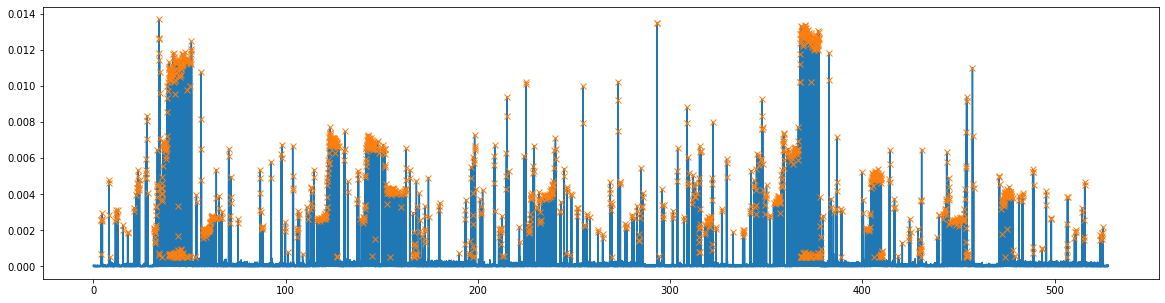

In [32]:
#graphy the signal after filtering out the noise
plt.figure(figsize=(20,5))
plt.plot(x_time,hilbert_signal)
plt.plot(x_time[peaks], hilbert_signal[peaks], 'x')
#plt.xlim(40*44100, 41*44100)
plt.show()

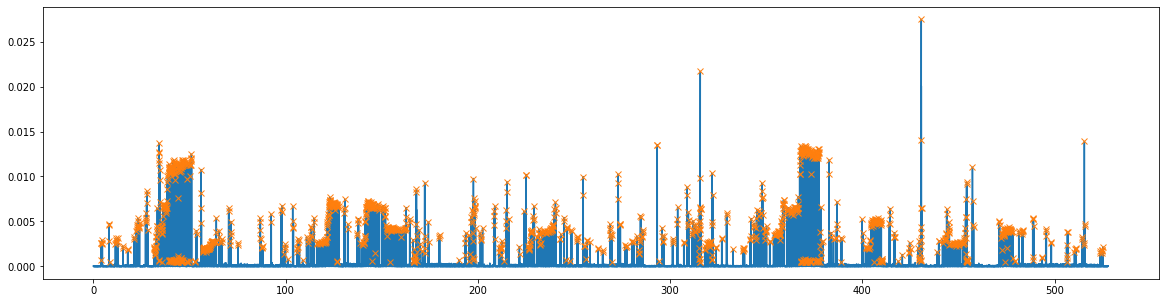

In [30]:
#this is the graph of signal before filtering out noise

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


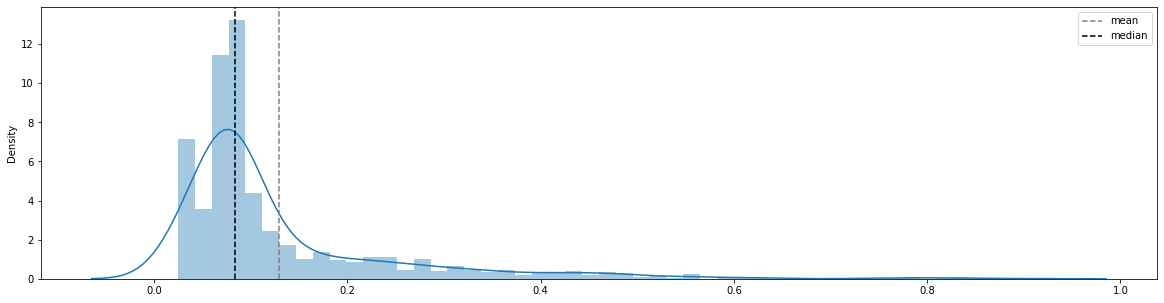

Mean:  0.1293573359474796 ; Median:  0.08430839002267732 ; STD:  0.12191390504923662


In [73]:
_,mean,median,std = get_rapping_IPI_stats(peaks,x_time)
print("Mean: ", mean,"; Median: ",median, "; STD: ", std)